# AFL Match Predictors

In [39]:
from matplotlib import pyplot as plt
import json
plt.style.use(['mvstyle', 'one_piece'])

import numpy as np
import requests
import pandas as pd
from os.path import isfile
from glob import glob
import re
import os

years = np.arange(1970, 2025)
headers = {'User-Agent':'MV_tipping_predictions'}

In [40]:
def get_team_info():

    '''
    Returns a dictionary to translate team name to ID number for use 
    in neural nets
    '''
    if not isfile('team_data.csv'):
        team_data = requests.get('https://api.squiggle.com.au/?q=teams;format=csv', headers=headers)

        with open('team_data.csv', 'w') as f:
            f.write(team_data.text)

    team_data = pd.read_csv('team_data.csv', index_col=None)
    # team_dict = team_data[['name', 'id']].to_dict('index')
    names = team_data['name'].to_numpy()
    ids = team_data['id'].to_numpy()

    team_dict = {name : id_ for id_, name in zip(ids, names)}

    return team_dict

## Data Processing 

In [41]:
for year in years:

    if isfile(f'Seasonal_Data/data_{year:d}.csv'):

        # print('Data already downloaded.')
        
        continue

    response = requests.get(f'https://api.squiggle.com.au/?q=games;year={year:d};format=csv', headers=headers)

    with open(f'Seasonal_Data/data_{year:d}.csv', 'w') as f:
        f.write(response.text)

Get the standings for each round

In [42]:
rounds = np.arange(1, 29)

for year in years:
    try:
        os.mkdir(f'Standings/{year:d}/')
    except:
        pass
    for round_ in rounds:

        if isfile(f'Standings/{year:d}/round_{round_:d}.csv'):

            # print('Data already downloaded.')
            
            continue
        
        response = requests.get(f'https://api.squiggle.com.au/?q=standings;year={year:d};round={round_};format=csv', headers=headers)

        with open(f'Standings/{year:d}/round_{round_:d}.csv', 'w') as f:
            f.write(response.text)

In [43]:
# Some helper functions for use later

def get_year(file):
    
    file = re.sub('^Seasonal_Data/data_', '', file)    
    file = file.rstrip('.csv')

    return int(file)

def get_round(file):
    
    file = re.sub('^Standings/\w+/round_', '', file)    
    file = file.rstrip('.csv')

    return int(file)

def read_ranking(file):

    _round = get_round(file)

    _df  = pd.read_csv(file)

    _df.insert(loc=0, column='round', value=_round * np.ones(len(_df), dtype= int))

    return _df


In [44]:
# Function to read in ranking, number of wins and number of losses
# for each team for each round

def standings_data(year):
    rank_files = glob(f'Standings/{year:d}/*')

    standings_frame = pd.concat(read_ranking(file) for file in rank_files)

    # Fill NaN values for rank in finals rounds with the mean of the 
    # team's rank # throughout the season
    standings_frame['rank'] = standings_frame['rank'].fillna(
        standings_frame.groupby('id')['rank'].transform('mean')
        )

    standings_frame = standings_frame[['round', 'id', 'rank', 'wins','losses']]
    standings_frame = standings_frame.sort_values('round')
    standings_frame = standings_frame.reset_index(drop=True)

    return standings_frame

In [45]:
def merge_standings(main_data, standings_data):

    lookup = standings_data[['round', 'id', 'rank', 'wins', 'losses']]

    # Merge with standings_data to filter matching rows
    for prefix in ['h', 'a']:

        filtered_main_data = main_data.merge(lookup, left_on=['round', f'{prefix}teamid'], right_on=['round', 'id'], how='inner')
        filtered_main_data = filtered_main_data.rename(columns= {'rank':f'{prefix}rank', 'wins': f'{prefix}wins', 'losses': f'{prefix}losses'})
        main_data = filtered_main_data.drop('id', axis=1)

    return main_data


Team info to tranlate ID and team name

Create a function to process the raw data into the statistics we want

In [46]:
def process_season_data(datafile):

    # Select relevant columns

    dataframe = pd.read_csv(datafile)

    dataframe = dataframe[['round', 'hteamid', 'ateamid', 'hscore', 
                           'ascore', 'hgoals', 'agoals', 'hbehinds', 
                           'abehinds', 'is_final', 'winnerteamid']].copy()

    # Fill NaN values in winnerteamid
    dataframe['winnerteamid'] = dataframe['winnerteamid'].fillna(0)

    # Compute hteamwin using np.where()
    dataframe['hteamwin'] = np.where(
        dataframe['winnerteamid'] == 0, 2, 
        np.where(dataframe['winnerteamid'] == dataframe['hteamid'], 1, 0)
    )



    # Compute expanding mean for each team using groupby()
    column_team_mapping = { 
        'hscore': 'hteamid', 'hgoals': 'hteamid', 'hbehinds': 'hteamid', 
        'ascore': 'ateamid', 'agoals': 'ateamid', 'abehinds': 'ateamid' 
        }

    # Compute expanding means efficiently in a single loop
    for col, team_col in column_team_mapping.items():
        dataframe[f'{col}_ppg'] = (
            dataframe.groupby(team_col)[col]
            .expanding().mean()
            .reset_index(level=0, drop=True)
        )
    
    year = get_year(datafile)
    dataframe = merge_standings(dataframe, standings_data(year))

    # Select final columns
    final_data = dataframe[['round', 
                            'hteamid', 'ateamid',
                            'hrank', 'arank', 
                            'hscore_ppg', 'ascore_ppg', 
                            'hgoals_ppg', 'agoals_ppg', 
                            'hbehinds_ppg', 'abehinds_ppg', 
                            'hwins', 'awins', 
                            'hlosses', 'alosses',  
                            'is_final', 'hteamwin']].copy()
    
    
    return final_data

Combine all seasonal data into one DataFrame

In [47]:
data_files = glob('Seasonal_Data/data_*.csv')
full_data = pd.concat(process_season_data(file) for file in data_files)
full_data

,round,hteamid,ateamid,hrank,arank,hscore_ppg,ascore_ppg,hgoals_ppg,agoals_ppg,hbehinds_ppg,abehinds_ppg,hwins,awins,hlosses,alosses,is_final,hteamwin
0,1,3,19,5.000000,8.000000,81.000000,70.000000,11.000000,10.000000,15.000000,10.000000,1,0,0,1,0,1
1,1,10,11,3.000000,10.000000,104.000000,75.000000,15.000000,10.000000,14.000000,15.000000,1,0,0,1,0,1
2,1,15,12,2.000000,11.000000,134.000000,76.000000,20.000000,11.000000,14.000000,10.000000,1,0,0,1,0,1
3,1,14,4,6.000000,7.000000,105.000000,101.000000,16.000000,14.000000,9.000000,17.000000,1,0,0,1,0,1
4,1,16,7,4.000000,9.000000,73.000000,61.000000,10.000000,9.000000,13.000000,7.000000,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,20,14,15,5.944444,6.055556,68.222222,61.200000,10.000000,9.000000,8.222222,7.200000,13,11,5,8,4,1
158,20,7,4,4.833333,6.166667,80.200000,56.454545,12.000000,8.272727,8.200000,6.818182,13,10,6,8,4,1
159,21,13,14,1.000000,5.944444,70.181818,63.727273,10.181818,9.090909,9.090909,9.181818,15,14,4,5,5,0
160,21,2,7,3.611111,4.833333,71.636364,65.500000,10.000000,9.300000,11.636364,9.700000,15,14,4,6,5,0


## Neural Nets

### Process data for use in neural nets

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

In [35]:
class PandasDataset(Dataset):

    def __init__(self, dataframe):
        self.data = dataframe.drop(columns=['hteamwin']).values  # Features
        self.labels = dataframe['hteamwin'].values.astype(np.int16)  # Targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y

In [36]:
main_data = PandasDataset(full_data)


train_proportion = 0.7
val_proportion = 1.0 - train_proportion

batch_size = 100

train_data, val_data = train_test_split(main_data, train_size=train_proportion, shuffle=True, random_state=42)

train_loader = DataLoader(train_data, 
                          shuffle=True, 
                          num_workers=2, 
                          batch_size=batch_size
                          )

val_loader = DataLoader(val_data, 
                        shuffle=True, 
                        num_workers=2, 
                        batch_size=batch_size
                        )

NameError: name 'full_data' is not defined

Test speed of data loader

In [ ]:
import time
tstart=time.time()
num_iter=100
ctr=num_iter
for batch in train_loader:
    ctr -=100
    if ctr <= 0: break
print((time.time()-tstart)/num_iter,'[s/iteration]')

0.005278680324554443 [s/iteration]


### Dense Neural Net

Define the neural network architecture

In [37]:
hidden_nodes = 24
output_nodes = 3

class DenseNN(nn.Module):
    def __init__(self,inputNum):

        super(DenseNN, self).__init__()
        
        self.inputNum=inputNum
        
        self.fc1 = nn.Linear(in_features=inputNum, out_features=hidden_nodes)  # Input layer
        self.fc2 = nn.Linear(in_features=hidden_nodes, out_features=hidden_nodes)     # Hidden layer
        self.fc3 = nn.Linear(in_features=hidden_nodes, out_features=hidden_nodes)     # Hidden layer
        self.fc4 = nn.Linear(in_features=hidden_nodes, out_features=hidden_nodes)     # Hidden layer
        # self.fc5 = nn.Linear(in_features=hidden_nodes, out_features=hidden_nodes)     # Hidden layer
        self.fc5 = nn.Linear(in_features=hidden_nodes, out_features=output_nodes)     # Output layer

    def forward(self, x):
        
        x = x.view(-1, self.inputNum)   # Flatten the input
        
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        # x = torch.relu(self.fc5(x))
        x = self.fc5(x)

        return F.softmax(x, dim=1)
        # return x

In [26]:
input_num = main_data[0][0].__len__()
model = DenseNN(input_num)


# # Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 40
for epoch in range(num_epochs):

  print("In epoch: ", epoch)
  
  running_loss_train = []
  running_loss_val = []
  
  index = 0
  
  for batch in train_loader:
      
      index = index + 1
      inputs, labels = batch
      # labels = labels.view(-1, 1) 
      optimizer.zero_grad()
      # print(labels)

      # Forward propagation
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      
      # Backward propagation and optimize
      loss.backward()
      optimizer.step()
      running_loss_train.append(loss.item())

      if index % 10 == 9:    # Print every 100 mini-batches
        print("batch: ", index, " loss = " , np.mean(np.asarray(running_loss_train)))

  print("End train epoch, mean loss: ", np.mean(np.asarray(running_loss_train)))
  index = 0
  for batch in val_loader:
      index = index+1
      inputs, labels = batch
      # labels = labels.view(-1, 1) 
      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, labels)

      running_loss_val.append(loss.item())
      if index % 10 == 9:    # Print every 100 mini-batches
        print("batch: ", index, " loss = " , np.mean(np.asarray(running_loss_val)))

  print("End val epoch, mean loss: ", np.mean(np.asarray(running_loss_val)))

print('Finished Training')

In epoch:  0


batch:  9  loss =  1.064986679289076
batch:  19  loss =  1.0195106738492061
batch:  29  loss =  0.9852241257141376
batch:  39  loss =  0.9605697225301694
batch:  49  loss =  0.9400070127175779
batch:  59  loss =  0.9198181194774175
End train epoch, mean loss:  0.9077584805773266
batch:  9  loss =  0.7801739176114401
batch:  19  loss =  0.7904747599049619
batch:  29  loss =  0.7871832662615282
End val epoch, mean loss:  0.7871832662615282
In epoch:  1
batch:  9  loss =  0.7970087395773994
batch:  19  loss =  0.7835759457788969
batch:  29  loss =  0.7836184707181207
batch:  39  loss =  0.7837470586483295
batch:  49  loss =  0.783021825916913
batch:  59  loss =  0.7792665897789648
End train epoch, mean loss:  0.7788864302991042
batch:  9  loss =  0.7596496012475755
batch:  19  loss =  0.7608277640844646
batch:  29  loss =  0.7671832771136843
End val epoch, mean loss:  0.7671832771136843
In epoch:  2
batch:  9  loss =  0.7616101106007894
batch:  19  loss =  0.7641948304678264
batch:  29  l

Model working at 79.2% accuracy


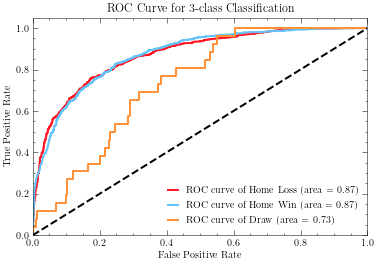

In [27]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_target = []
y_pred = []
for batch in val_loader:
      
      inputs, labels = batch
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      numpy_array = outputs.detach().numpy()
      y_target.extend(labels.numpy())
      y_pred.extend(numpy_array)


y_target = np.array(y_target)  # Example true labels
y_pred = np.array(y_pred)

pred_vals = [x.argmax() for x in y_pred]
mask = pred_vals == y_target
accuracy = mask.sum()/len(mask) * 100
print(f'Model working at {accuracy:0.1f}% accuracy')


target_labels = ["Home Loss", "Home Win", "Draw"]

def plot_roc_curve(y_true, y_pred_prob):

    # Binarize the labels
    y_true_binarized = label_binarize(y_true, classes=[0, 1, 2])

    column_sums = np.sum(y_true_binarized, axis=0)
    # print(column_sums)
    # print(y_true_binarized)
    # print(y_pred_prob)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(target_labels)):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure()
    # colors = ['blue', 'red', 'green', 'orange']
    for i in range(len(target_labels)):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label='ROC curve of {0} (area = {1:0.2f})'
                 ''.format(target_labels[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for 3-class Classification')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(y_target, y_pred)

Save the trained model for later use

In [28]:
torch.save(model.state_dict(), 'AFL_prediction_model_DNN.pth')

## Predicting upcoming games

Load the saved model

In [38]:
model = DenseNN(16)
model.load_state_dict(torch.load('AFL_prediction_model_DNN.pth', weights_only=True))

<All keys matched successfully>

In [ ]:
team_dict = get_team_info()

{'Adelaide': 1,
 'Brisbane Lions': 2,
 'Carlton': 3,
 'Collingwood': 4,
 'Essendon': 5,
 'Fremantle': 6,
 'Geelong': 7,
 'Gold Coast': 8,
 'Greater Western Sydney': 9,
 'Hawthorn': 10,
 'Melbourne': 11,
 'North Melbourne': 12,
 'Port Adelaide': 13,
 'Richmond': 14,
 'St Kilda': 15,
 'Sydney': 16,
 'West Coast': 17,
 'Western Bulldogs': 18}

In [16]:
current_year = 2024

season_data = pd.read_csv(f'Seasonal_Data/data_{current_year:d}.csv')

In [ ]:

ateamid = 1
hteamid = 2
season_data[season_data['ateamid']==ateamid].iloc[-1]

abehinds                           12
agoals                             13
ascore                             90
ateam                        Adelaide
ateamid                             1
complete                          100
date              2024-08-24 19:40:00
hbehinds                           13
hgoals                             18
hscore                            121
hteam                          Sydney
hteamid                            16
id                              35904
is_final                            0
is_grand_final                      0
localtime         2024-08-24 19:40:00
round                              24
roundname                    Round 24
timestr                     Full Time
tz                             +10:00
unixtime                   1724492400
updated           2024-08-24 22:20:37
venue                          S.C.G.
winner                         Sydney
winnerteamid                     16.0
year                             2024
Name: 203, d